In [8]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import geojson
import haversine as hs
import contextily as cx
import folium 
import geopy.distance
from tqdm.notebook import tqdm, trange
import osmnx as ox
import networkx as nx
from operator import itemgetter
import time
import math
import itertools
from scipy.spatial import cKDTree

In [15]:
houses=pd.read_excel('Cubo_202111_NOVAIMS.xlsx')
houses1=pd.read_excel("Cubo_202111_NOVAIMS_2022-01-21.xlsx")
houses2=pd.read_excel("Cubo_202201_NOVAIMS_2022-03-07.xlsx")

In [1]:
houses2.rename(columns={'PRECO_VENDA_OBSERVADO':'PRECO_VENDA'},inplace=True)

In [2]:
lxhouses = pd.concat([houses, houses1, houses2])

In [3]:
lxhouses[['COD_POST_4','COD_POS_3']]=lxhouses['CP7'].str.split('-', expand=True)

In [19]:
lxhouses.drop(lxhouses.index[lxhouses['COD_POST_4'] > '1999'], inplace=True)

In [1]:
lxhouses = gpd.GeoDataFrame(
    lxhouses, geometry=gpd.points_from_xy(lxhouses['LONGITUDE'], lxhouses['LATITUDE']))

In [21]:
lxhouses = lxhouses.set_crs(epsg=4326)

In [22]:
lxhouses = lxhouses.to_crs(epsg=3395)

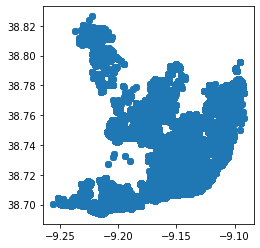

In [21]:
ax = lxhouses.plot()

In [25]:
df_distances = pd.read_csv('building_amenities_network_distance.csv')
df_distances.head()

,index_o,index_d,distance
0,1.350945e+09,4.392370e+09,10.304333
1,2.592792e+08,4.392370e+09,6.001080
2,4.390212e+09,4.392370e+09,3.037467
3,6.775993e+09,4.392370e+09,3.935827
4,2.549410e+08,4.392370e+09,5.326573


In [2]:
result = lxhouses.copy()
result.drop(['TIPO_IMOVEL','N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA',
       'CP7', 'LATITUDE', 'LONGITUDE', 'GARAGEM', 'TERRACO', 'PISCINA',
      'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO',
       'ULTIMA_DATA_EM_MERCADO', 'DATA_OFERTA_INICIAL', 'VALOR_OFERTA_INICIAL',
       'VALOR_OFERTA_ATUAL_FINAL', 'PRECO_VENDA', 'FLAG_PRECO_VENDA',
       'INDICE_MAIS_RECENTE', 'INDICE_ULTIMA_DATA_EM_MERCADO', 'COD_POST_4',
       'COD_POS_3', 'DATA_OFERTA_INCIAL', 'PRECO_VENDA_ESTIMADO'],axis=1,inplace=True)

### Códigos Postais mais caros - 1050;1250;1400;1990
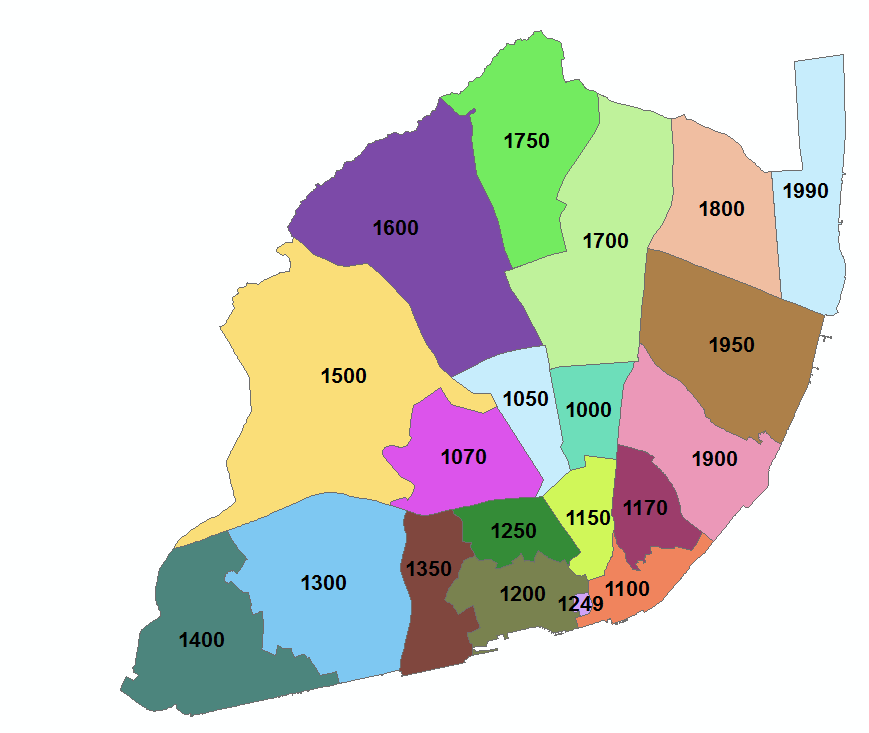

### Avenidas Novas, Estrela & Bairro Alto, Campolide, Belém, Parque das Nações; Campo de Ourique

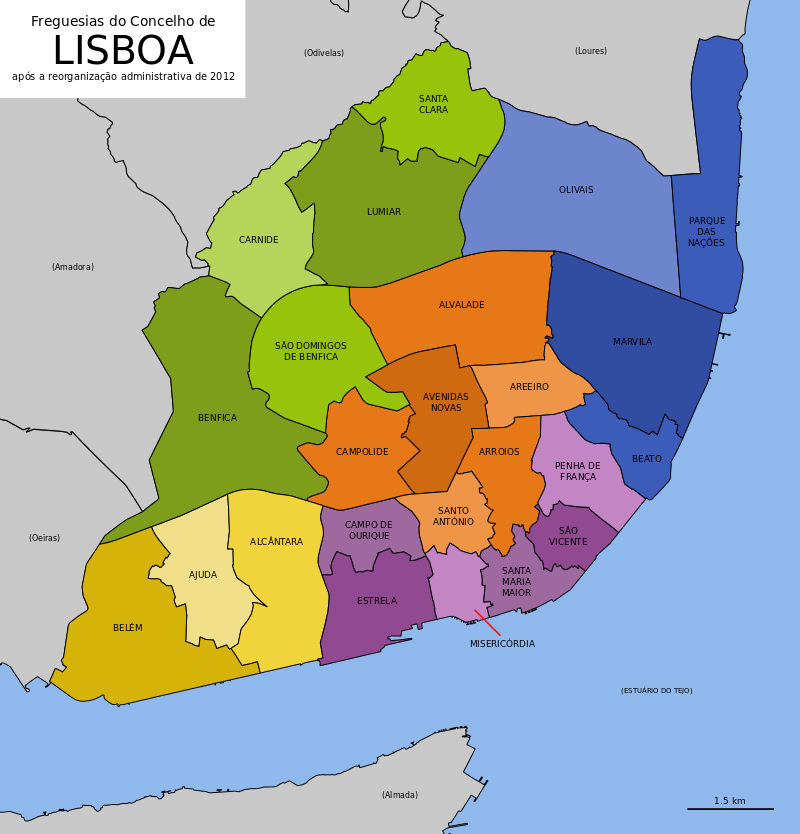

In [16]:
def ckdnearest(gdfA, gdfB):
    A = np.concatenate([np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]           
    B_ix = tuple(itertools.chain.from_iterable([itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k = 1)
    idx = itemgetter( * idx)(B_ix)
    names = gdfB.name
    gdf = pd.concat([gdfA, pd.Series(dist, name = str(names) + '_dist')], axis = 1)
    return gdf

In [17]:
def join_points(gdf, df):
    gdf = gpd.sjoin(gdf, df[['geometry']], how='left')
    name = df.name
    gdf = gdf.rename(columns={'index_right': str(name) + '_count'})
    return gdf

### Mobilidade

In [18]:
redefer =pd.read_csv('Rede Ferroviaria.csv')
redecomb =pd.read_csv('Rede Metro.csv')
redeMetro =pd.read_csv('Rede Comboio.csv')

In [84]:
redecomb = gpd.GeoDataFrame(
    redecomb, geometry=gpd.points_from_xy(redecomb.X, redecomb.Y))

In [85]:
redeMetro = gpd.GeoDataFrame(
    redeMetro, geometry=gpd.points_from_xy(redeMetro.X, redeMetro.Y))

In [24]:
metrocomboio = pd.concat([redecomb, redeMetro])

In [25]:
metrocomboio.drop(['X','Y','OBJECTID','ID','SITUACAO','LINHA'],axis=1,inplace=True)

In [27]:
ciclovias = gpd.read_file('Ciclovias.geojson')
estacoes = gpd.read_file('EstaciomentoBicicletas.geojson')

In [89]:
metrocomboio["Nome"] = metrocomboio["COD_SIG"].astype(str) +' ' + metrocomboio["NOME"]

In [88]:
estacoes["Nome"] = estacoes["OBJECTID"].astype(str) +' ' + estacoes["FREGUESIA"]

In [83]:
estacoes.drop(['OBJECTID','COD_SIG_ESTACIONAMENTO','COD_SIG_PROPOSTA','MORADA','MORADA_DETALHE','LOCALIZACAO',
           'FOTO','TIPO_ESTACIONAMENTO','NUM_SUPORTES','MODELO', 'CAPACIDADE',
           'FONTE_LEVANTAMENTO', 'BALIZADORES', 'DOMINIALIDADE', 'DATA_INSTALACAO',
           'SV_TIPO', 'SV_NUM_SERIE', 'ESTACIONAMENTO_ESTADO', 'EST_ESTADO_OBS',
           'OBS', 'DEPM_VALIDACAO', 'CTRL_EDICOES', 'COBERTO', 'COD_SIG', 'IDTIPO',
           'SE_ANNO_CAD_DATA', 'GlobalID','FREGUESIA'],axis=1,inplace=True)

In [31]:
metrocomboio.drop(['COD_SIG','IDTIPO','GlobalID','NOME'],axis=1,inplace=True)

In [82]:
# read text file into pandas DataFrame
bus = pd.read_csv("stops.txt", sep=",,")

In [34]:
bus[['Lat','Long']] = bus['stop_name'].str.split(',', expand=True)

In [3]:
bus = bus.drop(['stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station','Unnamed: 10', 'Unnamed: 11'], axis=1)

In [75]:
bus = gpd.GeoDataFrame(
    bus, geometry=gpd.points_from_xy(bus['Long'], bus['Lat']))

In [37]:
bus.drop(['stop_id','stop_name','Lat','Long'],axis=1,inplace=True)

In [39]:
bus.rename(columns={'stop_code':'Nome'},inplace=True)

In [76]:
girametrocomboiobus = pd.concat([metrocomboio, estacoes,bus])

In [42]:
girametrocomboiobus = girametrocomboiobus.set_crs(epsg=4326)
girametrocomboiobus = girametrocomboiobus.to_crs(epsg=3395)
girametrocomboiobus

,geometry,Nome
0,POINT (-1018138.268 4652960.838),35 Cais do Sodré
1,POINT (-1016813.143 4653104.514),34 Terreiro do Paço
2,POINT (-1017476.911 4653571.714),33 Baixa Chiado
3,POINT (-1015501.880 4654064.435),37 Santa Apolónia
4,POINT (-1017228.977 4654085.322),43 Rossio
...,...,...
2295,POINT (-1014081.043 4656083.932),XABREGAS
2296,POINT (-1014114.995 4655844.476),XABREGAS
2297,POINT (-1014509.289 4655779.106),XABREGAS
2298,POINT (-1014481.014 4655728.800),XABREGAS


In [77]:
girametrocomboiobus.name = 'transport'

In [78]:
gdfX = ckdnearest(result, girametrocomboiobus)

In [46]:
gdf_720_t = gpd.GeoDataFrame(gdfX.loc[:,gdfX.columns!='geometry'], geometry=gdfX.geometry.buffer(720))

In [48]:
gdf_720_t = join_points(gdf_720_t, girametrocomboiobus)

In [79]:
gdf_t = gdf_720_t.groupby(['IMOVEL_ID', 'transport_dist']).agg({'geometry': 'first', 'transport_count' : 'count'}).reset_index()

In [80]:
#gdf_t.drop([('geometry', 'first')],axis=1,inplace=True)

In [81]:
gdfX_ = gdfX.merge(gdf_t,on=['IMOVEL_ID'],how='left')
gdfX_.drop_duplicates(['IMOVEL_ID'],inplace=True)
gdfX_.drop([('transport_dist', '')],axis=1,inplace=True)

In [4]:
result_final = result.copy()
result_final = result_final.merge(gdfX_,on=['IMOVEL_ID'],how='left')

In [70]:
result_final.drop(['ID_y','geometry_y'],axis=1,inplace=True)

### Educação

In [90]:
# Dados educacao classificado como educação wiki OSM -  Atenção que inclui desde o acesso ao jardim de infancia até à faculdade.
education_ = {"amenity": ["college","kindergarten","school","university"]}
education_ = ox.geometries_from_place("Lisboa, Lisboa, Portugal", education_, buffer_dist=1500)
education_.reset_index(inplace=True)

In [75]:
education_.rename(columns={'name':'NOME'},inplace=True)

In [76]:
education_ = education_.set_crs(epsg=4326)

In [4]:
education_ = education_.to_crs(epsg=3395)

In [6]:
education_['geometry'] = education_['geometry'].centroid

In [87]:
education_.name = 'education'

In [7]:
gdf4 = ckdnearest(result,education_)

In [12]:
gdf_720_ed = gpd.GeoDataFrame(gdf4.loc[:,gdf4.columns!='geometry'], geometry=gdf4.geometry.buffer(1100))

In [11]:
gdf_720_ed = join_points(gdf_720_ed, education_)

In [10]:
gdf_ed = gdf_720_ed.groupby(['IMOVEL_ID', 'education_dist']).agg({'geometry':'first', 'education_count':'count'}).reset_index()

In [9]:
gdf_ed.drop([('geometry', 'first')],axis=1,inplace=True)

In [8]:
gdfed_ = gdf4.merge(gdf_ed,on=['IMOVEL_ID'],how='left')
gdfed_.drop_duplicates(['IMOVEL_ID'],inplace=True)
gdfed_.drop([('education_dist', '')],axis=1,inplace=True)

In [5]:
result_final = result_final.merge(gdfed_,on=['IMOVEL_ID'],how='left')
result_final.drop(['ID','geometry'],axis=1,inplace=True)

### Saúde e Segurança

In [13]:
hospitais = {"amenity": ["clinic","dentist","doctors","hospital", "pharmacy"]} # tags do OSM
hospitais = ox.geometries_from_place("Lisboa, Lisboa, Portugal", hospitais, buffer_dist=1500)

In [14]:
hospitais.reset_index(inplace=True)

In [15]:
hospitais.rename(columns={'name':'NOME'},inplace=True)

In [16]:
government = {"amenity": ["courthouse", "fire_station","police","post_office", "townhall"]}
government = ox.geometries_from_place("Lisboa, Lisboa, Portugal", government, buffer_dist=1500)
government.reset_index(inplace=True)
government.rename(columns={'name':'NOME'},inplace=True)

In [17]:
emergency = pd.concat([hospitais,government])
emergency = emergency.to_crs(epsg=3395)

In [18]:
emergency['geometry'] = emergency['geometry'].centroid

In [19]:
emergency.name='emergency'

In [21]:
gdf5 = ckdnearest(result,emergency)

In [23]:
gdf_720_sos = gpd.GeoDataFrame(gdf5.loc[:,gdf5.columns!='geometry'], geometry=gdf5.geometry.buffer(1100))

In [24]:
gdf_720_sos = join_points(gdf_720_sos, emergency)

In [25]:
gdf_sos = gdf_720_sos.groupby(['IMOVEL_ID', 'emergency_dist']).agg({'geometry':'first', 'emergency_count':'count'}).reset_index()

In [26]:
gdf_sos.drop([('geometry', 'first')],axis=1,inplace=True)

In [27]:
gdf_sos = gdf5.merge(gdf_sos,on=['IMOVEL_ID'],how='left')
gdf_sos.drop_duplicates(['IMOVEL_ID'],inplace=True)
gdf_sos.drop([('emergency_dist', '')],axis=1,inplace=True)

In [28]:
result_final = result_final.merge(gdf_sos,on=['IMOVEL_ID'],how='left')
result_final.drop(['ID','geometry'],axis=1,inplace=True)

## Greenspaces

In [53]:
# leisure
greenspaces = {"leisure": ["garden", "marina","park", "playground","swimming_area", "swimming_pool", "water_park"]}
greenspaces =  ox.geometries_from_place("Lisboa, Lisboa, Portugal", greenspaces, buffer_dist=1500)
greenspaces.reset_index(inplace=True)
greenspaces.rename(columns={'name':'NOME'},inplace=True)

In [54]:
greenspaces = greenspaces.to_crs(epsg=3395)

In [55]:
greenspaces['geometry'] = greenspaces['geometry'].centroid

In [56]:
greenspaces.name = 'greenspaces'

In [58]:
gdf = ckdnearest(result, greenspaces)

In [60]:
gdf_720 = gpd.GeoDataFrame(gdf.loc[:,gdf.columns!='geometry'], geometry=gdf.geometry.buffer(1100))

In [61]:
gdf_720_gs = join_points(gdf_720, greenspaces)

In [62]:
gdf_gs = gdf_720_gs.groupby(['IMOVEL_ID', 'greenspaces_dist']).agg({'geometry':'first', 'greenspaces_count':'count'}).reset_index()

In [63]:
gdf_gs.drop([('geometry', 'first')],axis=1,inplace=True)

In [64]:
gdf_gs = gdf.merge(gdf_gs,on=['IMOVEL_ID'],how='left')
gdf_gs.drop_duplicates(['IMOVEL_ID'],inplace=True)

In [65]:
result_final = result_final.merge(gdf_gs,on=['IMOVEL_ID'],how='left')
result_final.drop(['ID','geometry'],axis=1,inplace=True)

### Comercio & Cultura

In [66]:
comerce = gpd.read_file('RecenseamentoComercial.geojson')

In [115]:
comerce = comerce.to_crs(epsg=3395)

In [67]:
comerce.drop(['OBJECTID','COD_SIG','IDTIPO','MORADA','NUM_POLICIA','COD_POST_4','COD_POST_3','COD_ACT_ECON','DESC_ACT_ECON','ANO','TIPO','LOCALIZACAO','C_INTEGRADO','GlobalID'],axis=1,inplace=True)

In [68]:
comerce.name = 'comerce'

In [69]:
gdf2 = ckdnearest(result, comerce)

In [70]:
gdf_720_c = gpd.GeoDataFrame(gdf2.loc[:,gdf2.columns!='geometry'], geometry=gdf2.geometry.buffer(1100))
gdf_720_c = join_points(gdf_720_c, comerce)

In [71]:
gdf_c = gdf_720_c.groupby(['IMOVEL_ID', 'comerce_dist']).agg({'geometry':'first', 'comerce_count':'count'}).reset_index()

In [72]:
gdf_c.drop([('geometry', 'first')],axis=1,inplace=True)

In [73]:
gdf_c = gdf2.merge(gdf_c,on=['IMOVEL_ID'],how='left')
gdf_c.drop_duplicates(['IMOVEL_ID'],inplace=True)
gdf_c.drop([('comerce_dist', '')],axis=1,inplace=True)

In [74]:
result_final = result_final.merge(gdf_c,on=['IMOVEL_ID'],how='left')
result_final.drop(['ID','geometry'],axis=1,inplace=True)

### Edificios Públicos & Monumentos

In [52]:
imoveisIntPub = gpd.read_file('MoveisInteressePublico.geojson')
monumentos = gpd.read_file('Patrimonio.geojson')

In [51]:
finance = {"amenity": ["bank"]}
finance = ox.geometries_from_place("Lisboa, Lisboa, Portugal", finance, buffer_dist=1500)
finance.reset_index(inplace=True)
finance.rename(columns={'name':'INF_NOME'},inplace=True)

In [141]:
Imomonumentos = pd.concat([imoveisIntPub, monumentos, finance])

In [50]:
Imomonumentos = Imomonumentos.to_crs(epsg=3395)
Imomonumentos = Imomonumentos[['INF_NOME','geometry']]

In [49]:
Imomonumentos.name = 'PubBuilding'

In [48]:
Imomonumentos['geometry'] = Imomonumentos['geometry'].centroid

In [47]:
gdf3 = ckdnearest(result,Imomonumentos)

In [46]:
gdf_720_b = gpd.GeoDataFrame(gdf3.loc[:,gdf3.columns!='geometry'], geometry=gdf3.geometry.buffer(1100))

In [45]:
gdf_720_b = join_points(gdf_720_b, Imomonumentos)

In [44]:
gdf_b = gdf_720_b.groupby(['IMOVEL_ID', 'PubBuilding_dist']).agg({'geometry':'first', 'PubBuilding_count':'count'}).reset_index()

In [43]:
gdf_b.drop([('geometry', 'first')],axis=1,inplace=True)

In [42]:
gdf_b = gdf3.merge(gdf_b,on=['IMOVEL_ID'],how='left')
gdf_b.drop_duplicates(['IMOVEL_ID'],inplace=True)
gdf_b.drop([('PubBuilding_dist', '')],axis=1,inplace=True)

In [41]:
result_final = result_final.merge(gdf_b,on=['IMOVEL_ID'],how='left')

In [40]:
result_final.drop(['ID_x','geometry_x'],axis=1,inplace=True)

In [155]:
final = result_final.copy()

In [162]:
final.to_csv('final.csv')

### Score

In [2]:
#import pandas as pd
#from tqdm.notebook import tqdm
def feature_score(df_points, df_feature, name_feature):
    distance_df = pd.DataFrame(columns=['ID', f'{name_feature}_score', f'{name_feature}_score_200', f'{name_feature}_score_400'])

    for i in tqdm(df_points['ID'].values):
        a = df_feature['geometry'].distance(df_points.loc[df_points['ID'] == i]['geometry'].values[0]).reset_index()
        a = a.rename(columns={0: 'distance'})
        a = a.loc[a['distance'] <= 1000]
        score = sum([1/(1+dist) for dist in a['distance']])
        score_200 = sum([1/(1+(dist/200)) for dist in a['distance']])
        score_400 = sum([1/(1+(dist/400)) for dist in a['distance']])
        temp = pd.DataFrame([[i, score, score_200, score_400]], columns=['ID', f'{name_feature}_score', f'{name_feature}_score_200',           f'{name_feature}_score_400'])
        distance_df = distance_df.append(temp)

    distance_df = distance_df.reset_index(drop=True)
    
    return distance_df

### Scores for each Each Feature

In [29]:
comerce_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=comerce, name_feature='comerce')

In [30]:
transport_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=girametrocomboiobus, name_feature='transport')

In [39]:
scores = comerce_distance.merge(transport_distance,on=['ID'],how='left')

In [38]:
education_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=education_, name_feature='education')

In [37]:
scores = scores.merge(education_distance,on=['ID'],how='left')

In [36]:
emergency_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=emergency, name_feature='emergency')

In [35]:
scores = scores.merge(emergency_distance,on=['ID'],how='left')

In [34]:
greenspaces_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=greenspaces, name_feature='greenspaces')

In [33]:
scores = scores.merge(greenspaces_distance,on=['ID'],how='left')

In [32]:
PubBuild_distance = feature_score(df_points=result_final[['ID','geometry']],df_feature=Imomonumentos, name_feature='pubBuild')

In [31]:
scores = scores.merge(PubBuild_distance,on=['ID'],how='left')

In [1]:
comerce_distance.to_csv('comerce_distance.csv')
transport_distance.to_csv('transport_distance.csv')
education_distance.to_csv('education_distance.csv')
emergency_distance.to_csv('emergency_distance.csv')
greenspaces_distance.to_csv('greenspaces_distance.csv')
PubBuild_distance.to_csv('PubBuild_distance.csv')

### Shannon Diversity Index

In [86]:
result_final_ = pd.read_csv('final.csv',names=['IMOVEL_ID', 'transport_dist', 'transport_count',
       'education_dist', 'education_count', 'emergency_dist',
       'emergency_count', 'greenspaces_dist','greenspaces_dist_', 'greenspaces_count',
       'comerce_dist', 'comerce_count', 'ID', 'geometry','PubBuilding_dist', 'PubBuilding_count'])

In [6]:
result_final_['transport_count'] = result_final_['transport_count'].astype(float)
result_final_['education_count'] = result_final_['education_count'].astype(float)
result_final_['emergency_count'] = result_final_['emergency_count'].astype(float)
result_final_['greenspaces_count'] = result_final_['greenspaces_count'].astype(float)
result_final_['comerce_count'] = result_final_['comerce_count'].astype(float)
result_final_['PubBuilding_count'] = result_final_['PubBuilding_count'].astype(float)

In [6]:
acessibility = result_final_.copy()
acessibility.drop(['IMOVEL_ID','transport_dist','education_dist','emergency_dist','greenspaces_dist','greenspaces_dist_','comerce_dist','ID',
                   'geometry','PubBuilding_dist'],axis=1, inplace=True)
acessibility['C'] = acessibility.sum(axis=1)

p_it =  0.0001+ result_final_['transport_count']/ acessibility['C']
p_it_ = (p_it * np.log(p_it))

p_ied = 0.0001+ result_final_['education_count']/acessibility['C']
p_ied_ = (p_ied * np.log(p_ied))
 
p_isos =  0.0001+ result_final_['emergency_count']/acessibility['C']
p_isos_ = (p_isos * np.log(p_isos))

p_igs =  0.0001+ result_final_['greenspaces_count']/acessibility['C']
p_igs_ = (p_igs * np.log(p_igs))

p_ic = 0.0001+ result_final_['comerce_count']/ acessibility['C']
p_ic_ = (p_ic * np.log(p_ic))

p_ipb = 0.0001+ result_final_['PubBuilding_count']/ acessibility['C']
p_ipb_ = (p_ipb * np.log(p_ipb))

temp = [p_it_, p_ied_, p_isos_, p_igs_,p_ic_,p_ipb_]
result_final_['Shannon Diversity Index'] = sum(temp)*-1

In [32]:
result_final_copy = result_final_.copy()
result_final_copy.to_csv('scores&SHindex.csv')

In [12]:
resulta_final =pd.read_csv('scores&SHindex.csv')
resulta_final.drop(['geometry','Unnamed: 0'],axis=1, inplace=True)

C:\Users\Madal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
resulta_final

,IMOVEL_ID,transport_dist,transport_count,education_dist,education_count,emergency_dist,emergency_count,greenspaces_dist,greenspaces_dist_,greenspaces_count,comerce_dist,comerce_count,ID,PubBuilding_dist,PubBuilding_count,Shannon Diversity Index
0,45322,41.918857,276.0,222.890765,32.0,172.978577,120.0,177.499964,177.499964,92.0,30.321656,3576.0,0,273.131234,112.0,0.636907
1,568651,41.918857,276.0,222.890765,32.0,172.978577,120.0,177.499964,177.499964,92.0,30.321656,3576.0,1,273.131234,112.0,0.636907
2,43386,41.918857,138.0,222.890765,16.0,172.978577,60.0,177.499964,177.499964,46.0,30.321656,1788.0,2,273.131234,56.0,0.636907
3,161314,41.918857,276.0,222.890765,32.0,172.978577,120.0,177.499964,177.499964,92.0,30.321656,3576.0,3,273.131234,112.0,0.636907
4,51025,41.918857,138.0,222.890765,16.0,172.978577,60.0,177.499964,177.499964,46.0,30.321656,1788.0,4,273.131234,56.0,0.636907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180571,478737,14.033706,48.0,192.191784,8.0,83.283446,14.0,112.618549,112.618549,22.0,54.474591,128.0,59305,78.651893,2.0,1.215086
180572,394846,14.033706,48.0,192.191784,8.0,83.283446,14.0,112.618549,112.618549,22.0,54.474591,128.0,59307,78.651893,2.0,1.215086
180573,539537,14.033706,48.0,192.191784,8.0,83.283446,14.0,112.618549,112.618549,22.0,54.474591,128.0,59309,78.651893,2.0,1.215086
180574,105993,14.033706,48.0,192.191784,8.0,83.283446,14.0,112.618549,112.618549,22.0,54.474591,128.0,59306,78.651893,2.0,1.215086
